# Multilayer Perceptron

By Charles Patterson

## Load, Split, Balance

In [1]:
#Read in the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("acs2017_census_tract_data.csv", encoding = "unicode_escape", low_memory = False)

In [2]:
#Remove any observations with missing data
df = df.dropna()

In [3]:
#Encode strings as integers
X = df.copy()

#I got some of this from class
from sklearn.preprocessing import LabelEncoder
encoders = dict()
encoders["State"] = LabelEncoder() # save the encoder
X["State"] = encoders["State"].fit_transform(X["State"])

In [4]:
#Making a y vector and droping a couple of variable that won't make an impact in out analysis bc they are IDs.
y = X["ChildPoverty"]
if "ChildPoverty" in df:
    del X["ChildPoverty"]
if "County" in df:
    del X["County"]
if "TractId" in df:
    del X["TractId"]

In [5]:
#Balance the dataset, ensuring roughtly equal counts in each class
y = pd.qcut(y, 4, labels = ["Very Poor", "Poor", "Moderate", "Rich"])
y.describe()
print(y.value_counts())

Very Poor    18229
Poor         18171
Rich         18170
Moderate     18148
Name: ChildPoverty, dtype: int64


In [6]:
#80/20 split of the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, stratify=y)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(58174, 34)
(58174,)
(14544, 34)
(14544,)


Balancing the test and train data will be very important.  In this data set, it may not matter since the dataset is fairly large with a few thousand data points.  That being said, it will be beneficial for the NN to have a similar amount of data points in each class to prevent the NN from predicting a single class for all of its predictions.

## Pre-processing

In [7]:
#From class
from scipy.special import expit
import sys
import pandas as pd

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term

In [8]:
#From class
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2)
            
            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)

            self.W1 -= self.eta * grad1
            self.W2 -= self.eta * grad2
            

        return self

In [9]:
params = dict(n_hidden=50, 
              C=1e-5, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=1e-5,  # learning rate
              random_state=1)

In [10]:
def transform(yhat):
    y = []
    for i in range(len(yhat)):
        if yhat[i] == 0: 
            y.append("Very Poor")
        elif yhat[i] == 1:
            y.append("Poor")
        elif yhat[i] == 2:
            y.append("Moderate")
        else:
            y.append("Rich")
    return y

In [11]:
%%time
from sklearn.metrics import accuracy_score
nn = TwoLayerPerceptron(**params)
nn.fit(X_train, y_train, print_progress=10)
yhat = nn.predict(X_test)
yhat = transform(yhat)
score1 = accuracy_score(y_test,yhat)
print('Test acc:',score1)

Epoch: 200/200

Test acc: 0.2521314631463146
CPU times: user 21 s, sys: 3.08 s, total: 24.1 s
Wall time: 15 s


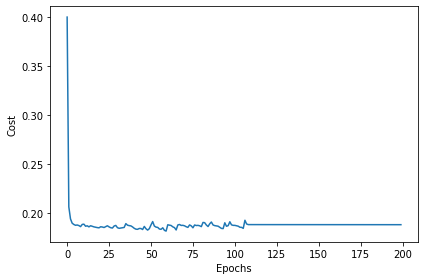

In [12]:
#Graph the loss function
def printNN(NN):
    plt.plot(range(len(NN.cost_)), NN.cost_)
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.show()
printNN(nn)

The above graph doesn't converge, and this is because the data has not been normalized or one hot encoded, which is a critical part of the data pre-processing.

In [13]:
#Normalize the data
"""from sklearn import preprocessing as p
normX = p.normalize(X)"""
normX=(X-X.mean())/X.std()

In [14]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(normX,y,test_size = 0.2, stratify=y)

Epoch: 200/200

Test acc: 0.3281078107810781


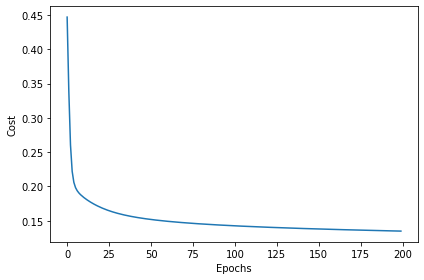

CPU times: user 22.6 s, sys: 6.04 s, total: 28.7 s
Wall time: 17.1 s


In [15]:
%%time 
nn2 = TwoLayerPerceptron(**params)
nn2.fit(X_train2, y_train2, print_progress=10)
yhat2 = nn.predict(X_test2)
yhat2 = transform(yhat2)
score2 = accuracy_score(y_test2,yhat2)
print('Test acc:',score2)
printNN(nn2)

This graph does a much better job of converging since the data has been normalized, but since the State variable has not been one hot encoded, the data can still be better processed.

In [16]:
#One hot encode and normalize the data
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
norm_and_onehotX = df.copy()
if "ChildPoverty" in norm_and_onehotX:
    del norm_and_onehotX["ChildPoverty"]
if "County" in norm_and_onehotX:
    del norm_and_onehotX["County"]
if "TractId" in norm_and_onehotX:
    del norm_and_onehotX["TractId"]
    
norm_and_onehotX = pd.DataFrame(ohe.fit_transform(df[["State"]].values))
norm_and_onehotX = (X-X.mean())/X.std()

In [17]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(norm_and_onehotX,y,test_size = 0.2, stratify=y)

Epoch: 200/200

Test acc: 0.3281078107810781


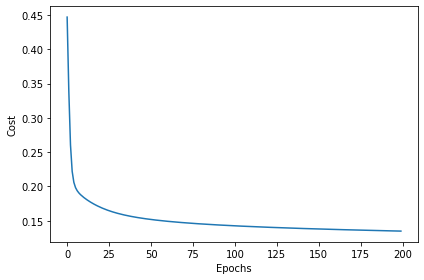

CPU times: user 22.7 s, sys: 6.05 s, total: 28.7 s
Wall time: 17 s


In [18]:
%%time 
nn3 = TwoLayerPerceptron(**params)
nn3.fit(X_train3, y_train3, print_progress=10)
yhat3 = nn.predict(X_test3)
yhat3 = transform(yhat3)
score3 = accuracy_score(y_test3,yhat3)
print('Test acc:',score3)
printNN(nn3)

## Comparing normalized and one hot encoded data preformance
Looking at the three graphs above, normalizing the data and one hot encoding the dat both made significant impacts.  This is likily because

In [19]:
from statsmodels.stats.proportion import proportions_ztest
count = [14544 * score1, 14544 * score2] #I took the accuracy scores and multiplied 
                                                                   #them by the number of observation in the test set
nobs = [14544, 14544]
print("Z-score: %.3f \nP-value %.3f" %(proportions_ztest(count, nobs)))

Z-score: -14.277 
P-value 0.000


In [20]:
from statsmodels.stats.proportion import proportions_ztest
count = [14544 * score1, 14544 * score3] #I took the accuracy scores and multiplied 
                                                                   #them by the number of observation in the test set
nobs = [14544, 14544]
print("Z-score: %.3f \nP-value %.3f" %(proportions_ztest(count, nobs)))

Z-score: -14.277 
P-value 0.000


In [21]:
from statsmodels.stats.proportion import proportions_ztest
count = [14544 * score2, 14544 * score3] #I took the accuracy scores and multiplied 
                                                                   #them by the number of observation in the test set
nobs = [14544, 14544]
print("Z-score: %.3f \nP-value %.3f" %(proportions_ztest(count, nobs)))

Z-score: 0.000 
P-value 1.000


In first two tests, I got a p-value of 0.000 which is less than alpha = 0.01, meaning both of these tests show a statistically significant difference in the models at a 99% confidence.  Therefore the one hot encode and normalized data and the normalized data are both statistically significantly better than just using the raw data.  However, there is not a statistically significant difference when going from one hot encoding to normalized data, becuase I have a p-value = 1 which is greater than 0.05.  This is likely because there is only one variable I am one hot encoding.  I beleive it is still best practice to one hot encode the data, but for the purposes of our dataset, it did not make a significant difference.

In [22]:
#To make the variable names easier to read
X = norm_and_onehotX
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, stratify=y)

## Adding Layers to the MLP

In [23]:
params = dict(n_hidden=50, 
              C=1e-5, # tradeoff L2 regularizer
              epochs=200, # iterations
              eta=1e-5,  # learning rate
              random_state=1)

In [24]:
# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class ThreeLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        
        W1_num_elems = (self.n_hidden) * (self.n_features_ + 1)
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden) * (self.n_hidden + 1)
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden, self.n_hidden + 1)
        
        W3_num_elems = (self.n_hidden + 1) * self.n_output_
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W3.reshape(self.n_output_, self.n_hidden + 1)
        
        return W1, W2, W3
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2))
    
    def _cost(self,A4,Y_enc,W1,W2,W3):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A4)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term

In [25]:
#From class
class ThreeLayerPerceptron(ThreeLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, W3):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._sigmoid(Z3)
        return A1, Z1, A2, Z2, A3, Z3, A4
    
    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        """ Compute gradient step using backpropagation.
        """
        
        # vectorized backpropagation
        V3 = -2*(Y_enc-A4)*A4*(1-A4)
        V2 = (A3 * (1 - A3)) * (W3.T @ V3)
        V1 = (A2 * (1 - A2)) * (W2.T @ V2[1:,:])
        
        grad3 = V3 @ A3.T
        grad2 = V2[1:,:] @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C

        return grad1, grad2, grad3
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, A4 = self._feedforward(X, self.W1, self.W2, self.W3)
        y_pred = np.argmax(A4, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3, Z3, A4 = self._feedforward(X_data,self.W1,self.W2, self.W3)
            
            cost = self._cost(A4,Y_enc,self.W1,self.W2,self.W3)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad1, grad2, grad3 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, Z1=Z1, Z2=Z2, Z3=Z3, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2, W3=self.W3)

            self.W1 -= self.eta * grad1
            self.W2 -= self.eta * grad2
            self.W3 -= self.eta * grad3
            

        return self

Epoch: 200/200

Test acc: 0.5602997799779978


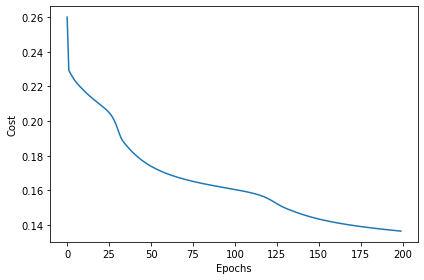

CPU times: user 44.8 s, sys: 10.8 s, total: 55.6 s
Wall time: 33.9 s


In [26]:
%%time
from sklearn.metrics import accuracy_score
nn = ThreeLayerPerceptron(**params)
nn.fit(X_train, y_train, print_progress=10)
yhat = nn.predict(X_test)
yhat = transform(yhat)
print('Test acc:',accuracy_score(y_test,yhat))
printNN(nn)

In [27]:
# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class FourLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_hidden) * (self.n_features_ + 1)
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden) * (self.n_hidden + 1)
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden, self.n_hidden + 1)
        
        W3_num_elems = (self.n_hidden) * (self.n_hidden + 1)
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W2.reshape(self.n_hidden, self.n_hidden + 1)
        
        W4_num_elems = (self.n_hidden + 1) * self.n_output_
        W4 = np.random.uniform(-1.0, 1.0, size=W4_num_elems)
        W4 = W4.reshape(self.n_output_, self.n_hidden + 1)    
        
        return W1, W2, W3, W4
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) 
                                       + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2))
    
    def _cost(self,A5,Y_enc,W1,W2,W3,W4):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A5)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4)
        return cost + L2_term

In [28]:
#From class
class FourLayerPerceptron(FourLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, W3, W4):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._sigmoid(Z3)
        A4 = self._add_bias_unit(A4, how='row')
        Z4 = W4 @ A4
        A5 = self._sigmoid(Z4)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5
    
    def _get_gradient(self, A1, A2, A3, A4, A5, Z1, Z2, Z3, Z4, Y_enc, W1, W2, W3, W4):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V4 = -2*(Y_enc-A5)*A5*(1-A5)
        V3 = (A4 * (1 - A4)) * (W4.T @ V4)
        V2 = (A3 * (1 - A3)) * (W3.T @ V3[1:,:])
        V1 = (A2 * (1 - A2)) * (W2.T @ V2[1:,:])
        
        grad4 = V4 @ A4.T
        grad3 = V3[1:,:] @ A3.T
        grad2 = V2[1:,:] @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C
        grad4[:, 1:] += W4[:, 1:] * self.l2_C

        return grad1, grad2, grad3, grad4
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, A5 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4)
        y_pred = np.argmax(A5, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5 = self._feedforward(X_data,self.W1,self.W2,self.W3,self.W4)
            
            cost = self._cost(A5,Y_enc,self.W1,self.W2,self.W3,self.W4)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad1, grad2, grad3, grad4 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, 
                                                     Y_enc=Y_enc, W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4)

            self.W1 -= self.eta * grad1
            self.W2 -= self.eta * grad2
            self.W3 -= self.eta * grad3
            self.W4 -= self.eta * grad4

        return self

Epoch: 200/200

Test acc: 0.5818894389438944


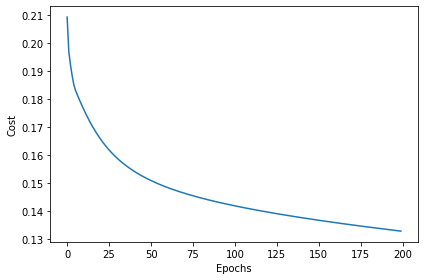

CPU times: user 1min 6s, sys: 16.2 s, total: 1min 22s
Wall time: 48 s


In [29]:
%%time
from sklearn.metrics import accuracy_score
nn = FourLayerPerceptron(**params)
nn.fit(X_train, y_train, print_progress=10)
yhat = nn.predict(X_test)
yhat = transform(yhat)
print('Test acc:',accuracy_score(y_test,yhat))
printNN(nn)

In [30]:
# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class FiveLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        rows, cols = (self.n_hidden, self.n_features_ + 1)
        
        W1_num_elems = (self.n_hidden) * (self.n_features_ + 1)
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden) * (self.n_hidden + 1)
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden, self.n_hidden + 1)
        
        W3_num_elems = (self.n_hidden) * (self.n_hidden + 1)
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W2.reshape(self.n_hidden, self.n_hidden + 1)
        
        W4_num_elems = (self.n_hidden) * (self.n_hidden + 1)
        W4 = np.random.uniform(-1.0, 1.0, size=W4_num_elems)
        W4 = W2.reshape(self.n_hidden, self.n_hidden + 1)
        
        W5_num_elems = (self.n_hidden + 1) * self.n_output_
        W5 = np.random.uniform(-1.0, 1.0, size=W5_num_elems)
        W5 = W5.reshape(self.n_output_, self.n_hidden + 1)
        
        return W1, W2, W3, W4, W5
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4, W5):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) 
                                       + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2) + np.mean(W5[:, 1:] ** 2))
    
    def _cost(self,A6,Y_enc,W1,W2,W3,W4,W5):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A6)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term

In [31]:
#From class
class FiveLayerPerceptron(FiveLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, W3, W4, W5):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._sigmoid(Z3)
        A4 = self._add_bias_unit(A4, how='row')
        Z4 = W4 @ A4
        A5 = self._sigmoid(Z4)
        A5 = self._add_bias_unit(A5, how='row')
        Z5 = W5 @ A5
        A6 = self._sigmoid(Z5)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6
    
    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V5 = -2*(Y_enc-A6)*A6*(1-A6)
        V4 = (A5 * (1 - A5)) * (W5.T @ V5)
        V3 = (A4 * (1 - A4)) * (W4.T @ V4[1:,:])
        V2 = (A3 * (1 - A3)) * (W3.T @ V3[1:,:])
        V1 = (A2 * (1 - A2)) * (W2.T @ V2[1:,:])
        
        grad5 = V5 @ A5.T
        grad4 = V4[1:,:] @ A4.T
        grad3 = V3[1:,:] @ A3.T
        grad2 = V2[1:,:] @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C
        grad4[:, 1:] += W4[:, 1:] * self.l2_C
        grad5[:, 1:] += W5[:, 1:] * self.l2_C
        
        return grad1, grad2, grad3, grad4, grad5
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, _, _, A6 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.W5)
        y_pred = np.argmax(A6, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data,self.W1,self.W2,self.W3,
                                                                           self.W4,self.W5)
            
            cost = self._cost(A6,Y_enc,self.W1,self.W2,self.W3,self.W4,self.W5)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad1, grad2, grad3, grad4, grad5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6, 
                                            Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                            Y_enc=Y_enc, W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4,W5=self.W5)

            self.W1 -= self.eta * grad1
            self.W2 -= self.eta * grad2
            self.W3 -= self.eta * grad3
            self.W4 -= self.eta * grad4
            self.W5 -= self.eta * grad5

        return self

Epoch: 200/200

Test acc: 0.5701320132013201


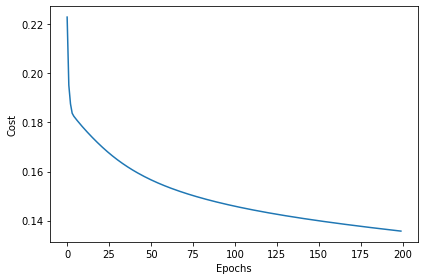

CPU times: user 1min 29s, sys: 21.9 s, total: 1min 51s
Wall time: 1min 3s


In [32]:
%%time
from sklearn.metrics import accuracy_score
nn = FiveLayerPerceptron(**params)
nn.fit(X_train, y_train, print_progress=10)
yhat = nn.predict(X_test)
yhat = transform(yhat)
print('Test acc:',accuracy_score(y_test,yhat))
printNN(nn)

In [33]:
# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class FiveLayerPerceptronBaseMomentum(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None, decrease_const = 0.1, alpha = 0.001):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.decrease_const = decrease_const
        self.alpha = alpha
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        rows, cols = (self.n_hidden, self.n_features_ + 1)
        
        W1_num_elems = (self.n_hidden) * (self.n_features_ + 1)
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden) * (self.n_hidden + 1)
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden, self.n_hidden + 1)
        
        W3_num_elems = (self.n_hidden) * (self.n_hidden + 1)
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W2.reshape(self.n_hidden, self.n_hidden + 1)
        
        W4_num_elems = (self.n_hidden) * (self.n_hidden + 1)
        W4 = np.random.uniform(-1.0, 1.0, size=W4_num_elems)
        W4 = W2.reshape(self.n_hidden, self.n_hidden + 1)
        
        W5_num_elems = (self.n_hidden + 1) * self.n_output_
        W5 = np.random.uniform(-1.0, 1.0, size=W5_num_elems)
        W5 = W5.reshape(self.n_output_, self.n_hidden + 1)
        
        return W1, W2, W3, W4, W5
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4, W5):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) 
                                       + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2) + np.mean(W5[:, 1:] ** 2))
    
    def _cost(self,A6,Y_enc,W1,W2,W3,W4,W5):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A6)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term

In [34]:
#From class
class FiveLayerPerceptronMomentum(FiveLayerPerceptronBaseMomentum):
    def _feedforward(self, X, W1, W2, W3, W4, W5):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._sigmoid(Z3)
        A4 = self._add_bias_unit(A4, how='row')
        Z4 = W4 @ A4
        A5 = self._sigmoid(Z4)
        A5 = self._add_bias_unit(A5, how='row')
        Z5 = W5 @ A5
        A6 = self._sigmoid(Z5)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6
    
    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V5 = -2*(Y_enc-A6)*A6*(1-A6)
        V4 = (A5 * (1 - A5)) * (W5.T @ V5)
        V3 = (A4 * (1 - A4)) * (W4.T @ V4[1:,:])
        V2 = (A3 * (1 - A3)) * (W3.T @ V3[1:,:])
        V1 = (A2 * (1 - A2)) * (W2.T @ V2[1:,:])
        
        grad5 = V5 @ A5.T
        grad4 = V4[1:,:] @ A4.T
        grad3 = V3[1:,:] @ A3.T
        grad2 = V2[1:,:] @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C
        grad4[:, 1:] += W4[:, 1:] * self.l2_C
        grad5[:, 1:] += W5[:, 1:] * self.l2_C
        
        return grad1, grad2, grad3, grad4, grad5
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, _, _, A6 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.W5)
        y_pred = np.argmax(A6, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)      

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5 = self._initialize_weights()
        
        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)
        delta_W3_prev = np.zeros(self.W3.shape)        
        delta_W4_prev = np.zeros(self.W4.shape)        
        delta_W5_prev = np.zeros(self.W5.shape)  

        self.cost_ = []
        for i in range(self.epochs):
            
            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data,self.W1,self.W2,self.W3,
                                                                           self.W4,self.W5)
            
            cost = self._cost(A6,Y_enc,self.W1,self.W2,self.W3,self.W4,self.W5)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad1, grad2, grad3, grad4, grad5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6, 
                                            Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5,
                                            Y_enc=Y_enc, W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4,W5=self.W5)

            # momentum calculations
            delta_W1 = self.eta * grad1
            delta_W2 = self.eta * grad2
            delta_W3 = self.eta * grad3
            delta_W4 = self.eta * grad4
            delta_W5 = self.eta * grad5

            self.W1 -= (delta_W1 + (self.alpha * delta_W1_prev))
            self.W2 -= (delta_W2 + (self.alpha * delta_W2_prev))
            self.W3 -= (delta_W3 + (self.alpha * delta_W3_prev))
            self.W4 -= (delta_W4 + (self.alpha * delta_W4_prev))
            self.W5 -= (delta_W5 + (self.alpha * delta_W5_prev))
            
            delta_W1_prev = delta_W1
            delta_W2_prev = delta_W2
            delta_W3_prev = delta_W3
            delta_W4_prev = delta_W4            
            delta_W5_prev = delta_W5

        return self

In [35]:
vals = { 'n_hidden':50, 
         'C':1e-5, 'epochs':200, 'eta':1e-5, 
         'alpha':0.005, 'decrease_const':1e-7,
         'random_state':1}

Epoch: 200/200

Test acc: 0.5705445544554455


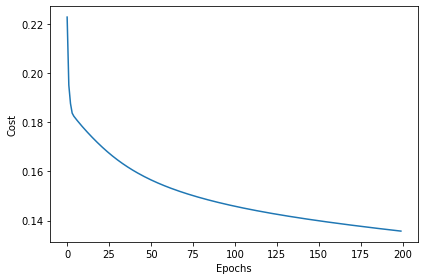

CPU times: user 1min 30s, sys: 22 s, total: 1min 52s
Wall time: 1min 3s


In [36]:
%%time
from sklearn.metrics import accuracy_score
nn = FiveLayerPerceptronMomentum(**vals)
nn.fit(X_train, y_train, print_progress=10)
yhat_momentum = nn.predict(X_test)
yhat_momentum = transform(yhat_momentum)
print('Test acc:',accuracy_score(y_test,yhat_momentum))
printNN(nn)

In [37]:
#Got this idea from https://machinelearningmastery.com/mcnemars-test-for-machine-learning/
from statsmodels.stats.contingency_tables import mcnemar
def mcnemarTest(table):
    # calculate mcnemar test
    result = mcnemar(table, exact=True)
    # summarize the finding
    print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
    # interpret the p-value
    alpha = 0.05
    if result.pvalue > alpha:
        print('Same proportions of errors (fail to reject H0)')
    else:
        print('Different proportions of errors (reject H0)')

In [40]:
yhat_momentum = np.array(yhat_momentum)
y_test = np.array(y_test)

In [44]:
#This compares raw data to normalized data

A = B = C = D = 0
for i in range(len(yhat)):
    if (yhat[i] == y_test[i]):
        if (yhat_momentum[i] == y_test[i]):
            A += 1
        else:
            B += 1
    else:
        if (yhat_momentum[i] == y_test[i]):
            C += 1
        else:
            D += 1

table = [[A,B], [C,D]]
mcnemarTest(table)

statistic=0.000, p-value=0.031
Different proportions of errors (reject H0)


Given a p-value = .031, and a alpha 0.05 there is sufficient evidence to conclude at a significance level of 95% to conclude that the two models are statistically significantly different.

## Exceptional Work

In [45]:
# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class FiveLayerPerceptronBaseMomentumSwish(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None, decrease_const = 0.1, alpha = 0.001, 
                 beta = 1, minibatches = 1):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.decrease_const = decrease_const
        self.alpha = alpha
        self.beta = beta
        self.minibatches = minibatches
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        rows, cols = (self.n_hidden, self.n_features_ + 1)
        
        W1_num_elems = (self.n_hidden) * (self.n_features_ + 1)
        W1 = np.random.normal(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden) * (self.n_hidden + 1)
        W2 = np.random.normal(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden, self.n_hidden + 1)
        
        W3_num_elems = (self.n_hidden) * (self.n_hidden + 1)
        W3 = np.random.normal(-1.0, 1.0, size=W3_num_elems)
        W3 = W2.reshape(self.n_hidden, self.n_hidden + 1)
        
        W4_num_elems = (self.n_hidden) * (self.n_hidden + 1)
        W4 = np.random.normal(-1.0, 1.0, size=W4_num_elems)
        W4 = W2.reshape(self.n_hidden, self.n_hidden + 1)
        
        W5_num_elems = (self.n_hidden + 1) * self.n_output_
        W5 = np.random.normal(-1.0, 1.0, size=W5_num_elems)
        W5 = W5.reshape(self.n_output_, self.n_hidden + 1)
        
        return W1, W2, W3, W4, W5
    
    def _activation(self, z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return z * expit(self.beta * z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4, W5):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) 
                                       + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2) + np.mean(W5[:, 1:] ** 2))
    
    def _cost(self,A6,Y_enc,W1,W2,W3,W4,W5):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A6)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term

In [46]:
#From class
class FiveLayerPerceptronMomentumSwish(FiveLayerPerceptronBaseMomentumSwish):
    def _feedforward(self, X, W1, W2, W3, W4, W5):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = W1 @ A1
        A2 = self._activation(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._activation(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._activation(Z3)
        A4 = self._add_bias_unit(A4, how='row')
        Z4 = W4 @ A4
        A5 = self._activation(Z4)
        A5 = self._add_bias_unit(A5, how='row')
        Z5 = W5 @ A5
        A6 = self._activation(Z5)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6
    
    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        """ Compute gradient step using backpropagation.
        """
        
        #Add bias to Z matricies
        Z1_bias = self._add_bias_unit(Z1, how='row')
        Z2_bias = self._add_bias_unit(Z2, how='row')
        Z3_bias = self._add_bias_unit(Z3, how='row')
        Z4_bias = self._add_bias_unit(Z4, how='row')
        Z5_bias = self._add_bias_unit(Z5, how='row')
        
        #Swish Gradients (Found from TensorFlow's implementation)
        V5 = -2*(Y_enc-A6)*A6*(1-A6)
        V4 = ((Z4_bias * A5) + A5 * (1 - (Z4_bias * A5))) * (W5.T @ V5)
        V3 = ((Z4_bias * A5) + A5 * (1 - (Z4_bias * A5))) * (W4.T @ V4[1:,:])
        V2 = ((Z4_bias * A5) + A5 * (1 - (Z4_bias * A5))) * (W3.T @ V3[1:,:])
        V1 = ((Z4_bias * A5) + A5 * (1 - (Z4_bias * A5))) * (W2.T @ V2[1:,:])
        
        grad5 = V5 @ A5.T
        grad4 = V4[1:,:] @ A4.T
        grad3 = V3[1:,:] @ A3.T
        grad2 = V2[1:,:] @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C
        grad4[:, 1:] += W4[:, 1:] * self.l2_C
        grad5[:, 1:] += W5[:, 1:] * self.l2_C
        
        return grad1, grad2, grad3, grad4, grad5
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, _, _, A6 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.W5)
        y_pred = np.argmax(A6, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)      

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5 = self._initialize_weights()
        
        delta_W1_prev = np.zeros(self.W1.shape)
        delta_W2_prev = np.zeros(self.W2.shape)
        delta_W3_prev = np.zeros(self.W3.shape)        
        delta_W4_prev = np.zeros(self.W4.shape)        
        delta_W5_prev = np.zeros(self.W5.shape)  

        self.cost_ = []
        self.score_ = []
        for i in range(self.epochs):
            
            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()
            
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:
                # feedforward all instances
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data,self.W1,self.W2,self.W3,
                                                                               self.W4,self.W5)

                cost = self._cost(A6,Y_enc,self.W1,self.W2,self.W3,self.W4,self.W5)
                mini_cost.append(cost)

                # compute gradient via backpropagation
                grad1, grad2, grad3, grad4, grad5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5, Y_enc=Y_enc, W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4,W5=self.W5)

                # momentum calculations
                delta_W1 = self.eta * grad1
                delta_W2 = self.eta * grad2
                delta_W3 = self.eta * grad3
                delta_W4 = self.eta * grad4
                delta_W5 = self.eta * grad5

                self.W1 -= (delta_W1 + (self.alpha * delta_W1_prev))
                self.W2 -= (delta_W2 + (self.alpha * delta_W2_prev))
                self.W3 -= (delta_W3 + (self.alpha * delta_W3_prev))
                self.W4 -= (delta_W4 + (self.alpha * delta_W4_prev))
                self.W5 -= (delta_W5 + (self.alpha * delta_W5_prev))

                delta_W1_prev = delta_W1
                delta_W2_prev = delta_W2
                delta_W3_prev = delta_W3
                delta_W4_prev = delta_W4            
                delta_W5_prev = delta_W5
                
            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))

        return self

In [47]:
vals = { 'n_hidden':50, 
 'C':1e-3, 'epochs':20, 'eta':1e-5, 
 'alpha':1e-3, 'decrease_const':1e-7,
 'random_state':1, 'beta':1, 'minibatches':50}

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in multiply
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in matmul
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in matmul
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in multiply
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in multiply
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in matmul
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in matmul
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in matmul
/opt/anaconda3/lib/python3.7/site-packages/ipy

Test acc: 0.2506875687568757


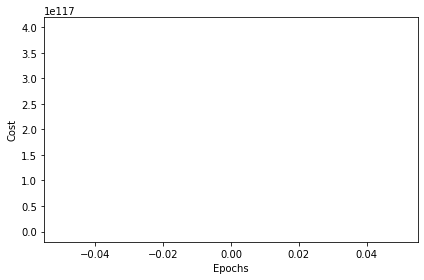

CPU times: user 8min 5s, sys: 2min 27s, total: 10min 32s
Wall time: 5min 50s


In [48]:
%%time
scores = []
nn = FiveLayerPerceptronMomentumSwish(**vals)
nn.fit(X_train, y_train, print_progress=10)
yhat = nn.predict(X_test)
yhat = transform(yhat)
print('Test acc:', accuracy_score(y_test,yhat))
printNN(nn)

I can earnstly say I tried my very best to implement swish.  I beleive I have the gradient calculation is right and I have the actual implementation of swish right, but I get this exploding gradient problem I can't seem to wrap my head around.  I attempted to using mini batching because I read somewhere this might help with that problem, but it doesn't seem to be working all that well.  I also attempted trying to fix it with the weight initilization from uniform to normal distibution.  I say all that because, if you do know what I missed, I would be very interested to know.  Thanks!